# Descriptives of stuff to present in Tuscany

In [1]:
import json
import os
import pickle
import psycopg2
import sqlalchemy
import pyproj
import time
import sys
sys.path.append("..")

import geopandas as gpd
from geopandas.geoseries import GeoSeries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pylab as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import matplotlib.animation as animation
from shapely.geometry import Point
from datetime import datetime
from dateutil.relativedelta import relativedelta
#import imageio
from IPython.display import Image
get_ipython().magic(u'matplotlib inline')
%matplotlib inline

from connect_db import db_connection

# filter annyoing warning from pandas
import warnings
warnings.filterwarnings('ignore')

In [2]:
username='ovasarhelyi'

In [3]:
cred_location = '/mnt/data/'+username+'/TPT_tourism/connect_db/data_creds_redshift.json.nogit'
db = db_connection.DBConnection(cred_location)

In [4]:
# Load maps data 

# load data from TPT (use this from now on)
regions = r"/mnt/data/shared/Boundaries regions and municipalities Italy 2016/Reg2016_WGS84_g/Reg_2016_WGS84_g.shp"
provinces = r"/mnt/data/shared/Boundaries regions and municipalities Italy 2016/CMProv2016_WGS84_g/CMprov2016_WGS84_g.shp"
territories =  r"/mnt/data/shared/Tus_28districts.shp"
municipalities = r"/mnt/data/shared/Boundaries regions and municipalities Italy 2016/Com2016_WGS84_g/Com2016_WGS84_g.shp"

# important cities 
important_cities_tuscany = r"/mnt/data/shared/important_cities.csv"

In [5]:
# Load files and select only Tuscany
# reg, pro, mun are for the whole italy
# ter is only for tuscany, and already in lat,lon coords

gdf_reg = gpd.read_file(regions)
gdf_pro = gpd.read_file(provinces)
gdf_ter = gpd.read_file(territories)
gdf_mun = gpd.read_file(municipalities)

# Convert coordinates in WGS84 to Lat Lon format 
# see http://geopandas.org/projections.html
gdf_reg['geometry'] = gdf_reg['geometry'].to_crs(epsg=4326)
gdf_pro['geometry'] = gdf_pro['geometry'].to_crs(epsg=4326)
gdf_mun['geometry'] = gdf_mun['geometry'].to_crs(epsg=4326)

# important cities 
important_cities_tuscany = r"/mnt/data/shared/important_cities.csv"
df_impcit = pd.read_csv(important_cities_tuscany)

# 9 is for Tuscany only
gdf_reg_tus = gdf_reg[gdf_reg["COD_REG"] == 9] 
gdf_pro_tus = gdf_pro[gdf_pro["COD_REG"] == 9]
gdf_ter_tus = gdf_ter # this one is already Tuscany only
gdf_mun_tus = gdf_mun[gdf_mun["COD_REG"] == 9]

In [6]:
# Helper functions for plotting the heatmaps

def heatmap_plot(gdf_map, ax, clog=False, header='count', colorbar=True, title=False):
    """
    Plot the Point counts heatmap per municipality
    
    Params:
        gdf_map: GeoDataFrame with the 'header' field - it should NOT contain zeros
        axis: Axis object with the figure elements
        header: str with the name of the field to be ploted
        colorbar: bool, include or not a colorbar in the plot
    """
    
    # create the new log column
    header_log = 'log_'+header
    gdf_map[header_log] = np.log(gdf_map[header])
    
    # cash some useful values
    if clog is False:
        clog_min = np.round(gdf_map[header_log].min(), 6)
        clog_max = np.round(gdf_map[header_log].max(), 6)
    else:
        clog_min = np.round(clog[0], 6)
        clog_max = np.round(clog[1], 6)
    clog_range = np.linspace(clog_min, clog_max, num=5)
    
    # plot
    gdf_map.plot(column=header_log, ax=ax, 
                 vmin=clog_min, vmax=clog_max,
                 cmap='Reds',
                 edgecolor='gray',
                 alpha=0.6)
    
    if title is not False:
        ax.set_title(title, fontsize=15)
    
    if colorbar:
    
        norm = Normalize(vmin=clog_min, vmax=clog_max)
        n_cmap = cm.ScalarMappable(norm=norm, cmap='Reds')
        n_cmap.set_array([])
        
        cbar = ax.get_figure().colorbar(n_cmap, fraction=0.03, ticks=clog_range)
        
        cbar.ax.set_yticks(clog_range)
        cbar.ax.set_yticklabels((np.exp(clog_range)/1000).astype(int))
        cbar.ax.set_ylabel('# unique visitors (thousands)', rotation=270, labelpad=25, fontsize=15) 
    
        
# there are 6 municipalities with 0 towers or visits:
# Capolona, Molazzana, Sassetta, Casale Maritimo, Filattiera, Tresana
def heatmap_replace_zeros(gdf_map, header='count'):
    """
    Replace zeros with the minimum positive count
    
    Params:
        gdf_map: GeoDataFrame with the 'header' field
        header: field in which zeros are replaced by the minimum value
    """    
    
    min_Point_count = np.array(gdf_map[header])
    gdf_map.loc[gdf_map[header]==0, header] = np.min(min_Point_count[np.nonzero(min_Point_count)])


def important_cities(df_impcit):
    """
    Include important cities in the plot
    
    Params:
        df_impcit: DataFrame with the 'lat', 'long', and 'city' fields
    """

    for i, name in enumerate(list(df_impcit.city)):
        plt.plot(df_impcit.long[i], df_impcit.lat[i], 'o', color='k', markersize=6)
        plt.annotate(name, (df_impcit.long[i]+0.03, df_impcit.lat[i]),
                     fontsize=15)

In [7]:
# function to run queries for the heatmap 
# this query already removes the customers from tuscany.excluded_customers

def query_count_territory(gdf_ter_map,
                          min_date = '2017-05-01 00:00:00', 
                          max_date = '2018-02-28 23:59:59'):
    '''
    Run the query for unique customers in each territory in a given time window
    
    Params:
        gdf_ter_map: GeoDataFrame with the field 'rown', loaded from /mnt/data/shared
        min_date: minimum date, in the yyy-mm-dd hh:mm:ss format
        max_date: maximum date, in the same format
        
    Returns:
        gdf_merged_map: GeoDataFrame with the unique counts for each territory
    '''

    query="""
    select count(distinct customer_id), location_dictionary.territory
    from tuscany.vodafone
    join tuscany.location_dictionary on location_dictionary.location_id = vodafone.location_id
    where time_stamp between '"""+min_date+"""' and '"""+max_date+"""'
    and customer_id not in (select customer_id from tuscany.excluded_customers)
    and territory is NOT NULL
    group by tuscany.location_dictionary.territory;
    """
    df_count_territory = db.sql_query_to_data_frame(query, cust_id=True)
    
    gdf_merged_map = gdf_ter_map.merge(df_count_territory.astype(int), how = 'inner', left_on='rown', right_on='territory')
    
    return gdf_merged_map

## Heatmaps per seasonality

In [9]:
# queries for each 'season' (takes around 2 min)

# create months datetime list
# minimum date is '2017-05-01 00:00:00'
# maximun date is '2017-28-02 23:59:59'
start_dt = datetime(2017, 4, 30, hour=23, minute=59, second=59)
end_dt = datetime(2018, 2, 28, hour=23, minute=59, second=59)
months_dt = []
for i in pd.date_range(start=start_dt, end=end_dt, freq='1M'):
    months_dt.append(str(i + relativedelta(hour=23, minute=59, second=59)))
    
# create dictionary with heatmaps for every month
heatmaps_per_month = {}
for i in range(len(months_dt)-1):
    
    month_start = months_dt[i]
    month_end = months_dt[i+1]
    
    gdf_month = query_count_territory(gdf_ter_tus, min_date = month_start, max_date = month_end)
    cur_month = datetime.strptime(months_dt[i+1], "%Y-%m-%d %H:%M:%S").strftime("%B")
    
    heatmaps_per_month[cur_month] = gdf_month  
    print(cur_month)
    
with open('heatmap_month/heatmaps_per_month.pickle', 'wb') as handle:
    pickle.dump(heatmaps_per_month, handle, protocol=pickle.HIGHEST_PROTOCOL)

May
June
July
August
September
October
November
December
January
February


In [ ]:
with open('/mnt/data/shared/heatmap_month/heatmaps_per_month.pickle', 'rb') as handle:
    heatmaps_per_month = pickle.load(handle)

In [10]:
heatmaps_per_month.keys()

dict_keys(['May', 'June', 'July', 'August', 'September', 'October', 'November', 'December', 'January', 'February'])

In [11]:
heatmaps_per_month['May'].head()

COD_REG  COD_CM  COD_PRO  PRO_COM NOME_TED  FLAG_CM     SHAPE_Leng  \
0        9       0       52    52001     None        2   38006.044646   
1        9       0      100   100001     None        2   49741.081267   
2        9       0       51    51002     None        2  112025.299215   
3        9       0       51    51004     None        2   49631.051762   
4        9     248       48    48003     None        1   57584.104550   

     SHAPE_Area  rown      District  \
0  5.890205e+07     1        Amiata   
1  9.558182e+07     2  Arca.Pratese   
2  3.837878e+08     3        Arezzo   
3  8.767509e+07     4     Casentino   
4  6.760215e+07     5       Chianti   

                                            geometry   count  territory  
0  POLYGON ((11.74601766829812 42.78575944027563,...   43358          1  
1  POLYGON ((11.06212465088694 43.81639246129403,...  124688          2  
2  POLYGON ((11.86421691033788 43.55692961358602,...  106451          3  
3  POLYGON ((11.91829455961145 43.64376805671598,...    7551          4  
4  POLYGON ((11.43587719650668 43.51161383763251,...  161412          5

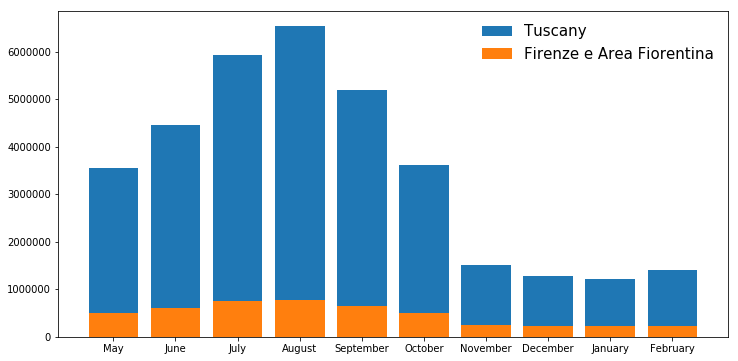

In [12]:
names = list(heatmaps_per_month.keys())
values = []
values_florence = []
for hm in heatmaps_per_month.values():
    values.append(hm['count'].sum())
    values_florence.append(int(hm.loc[hm['District'] == 'Firenze.e.Area.Fiorentina']['count']))

fig = plt.figure(figsize=(12, 6))
ax = plt.subplot(1,1,1)
plt.bar(range(len(names)), values, tick_label=names, label='Tuscany')
plt.bar(range(len(names)), values_florence, tick_label=names, label='Firenze e Area Fiorentina')
plt.legend(loc='best', frameon=False, fontsize=15)

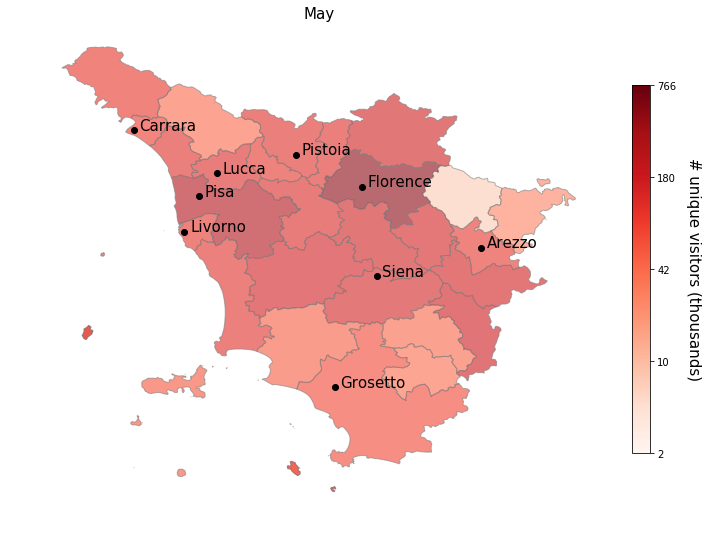

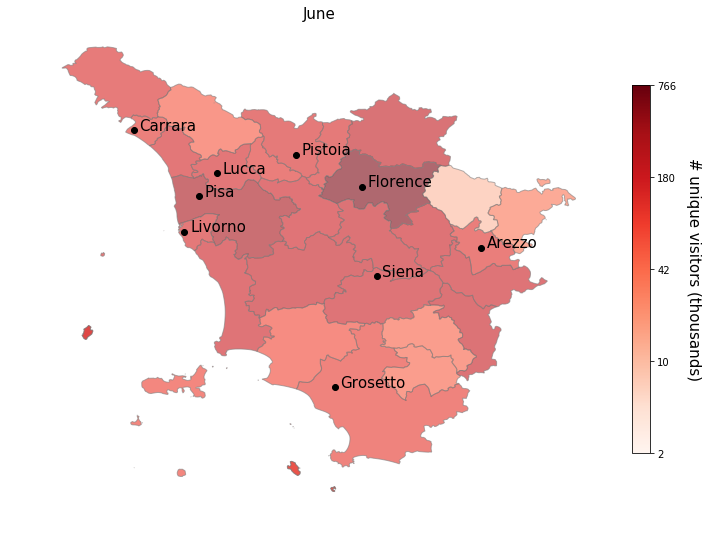

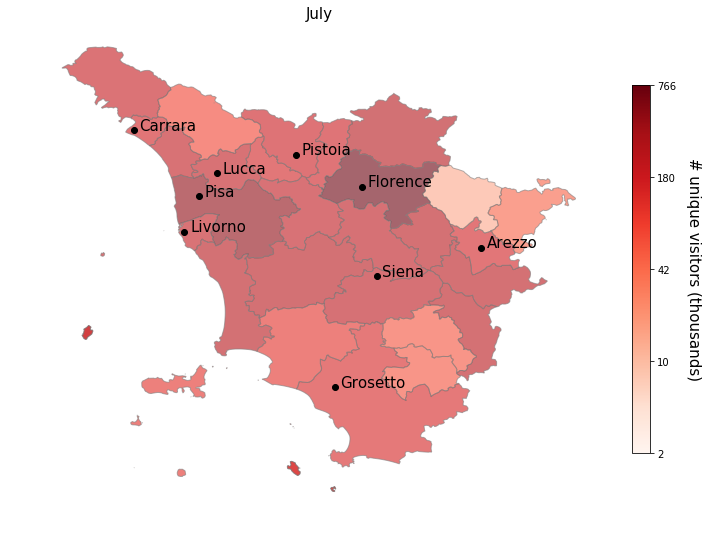

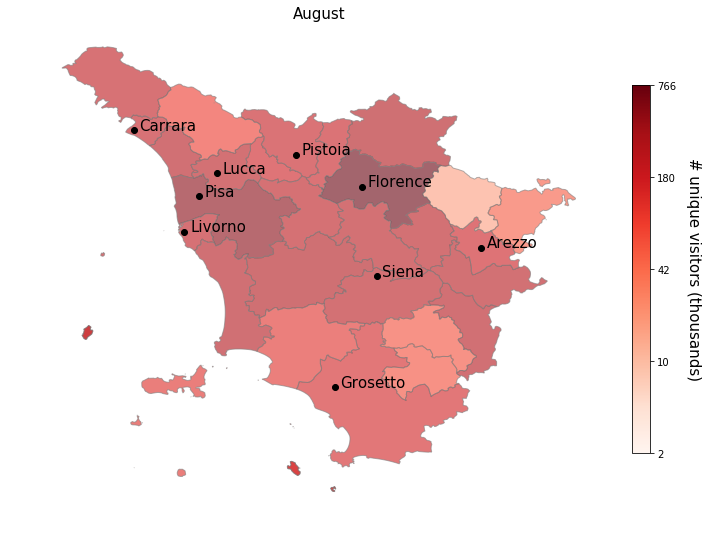

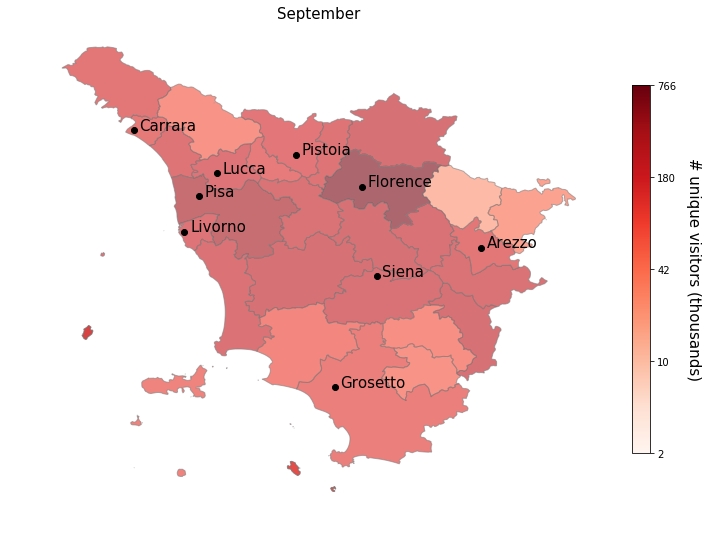

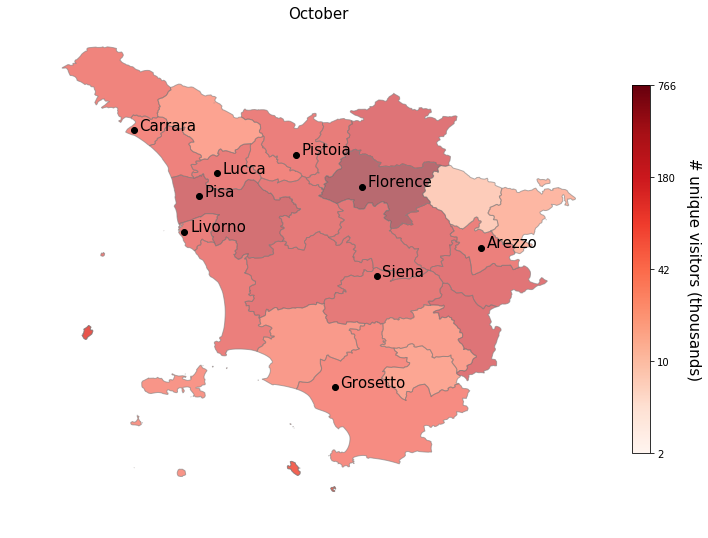

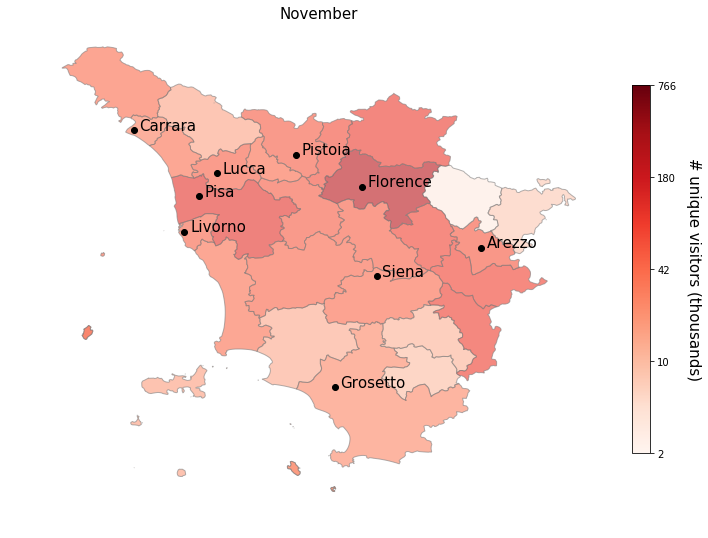

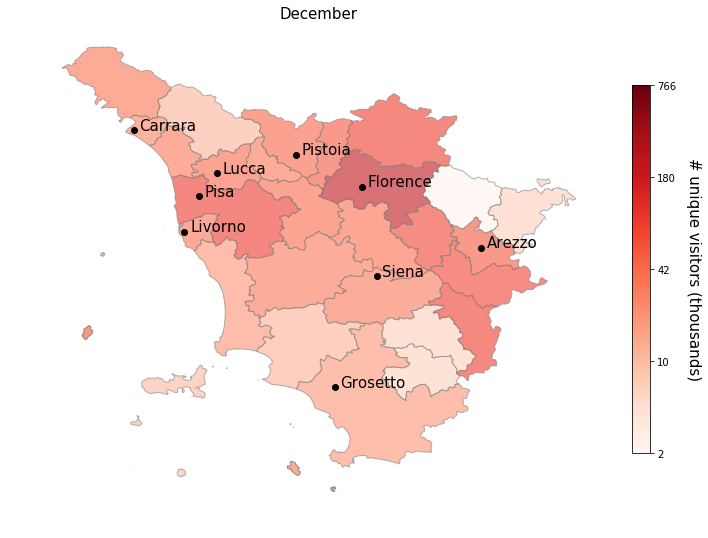

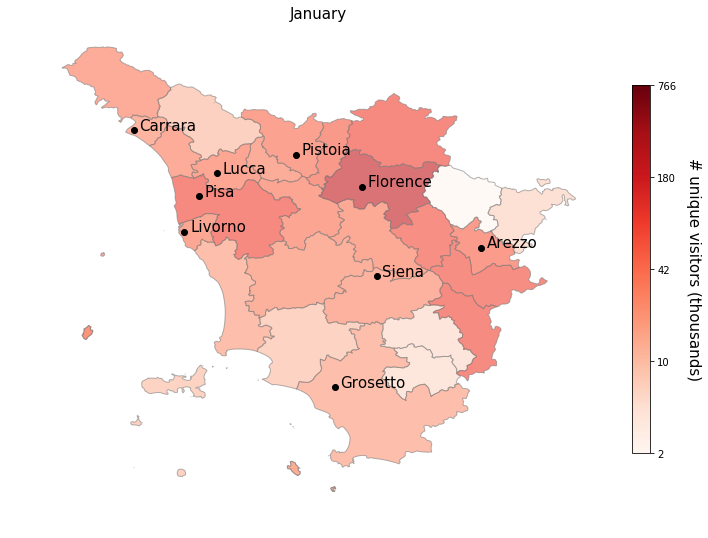

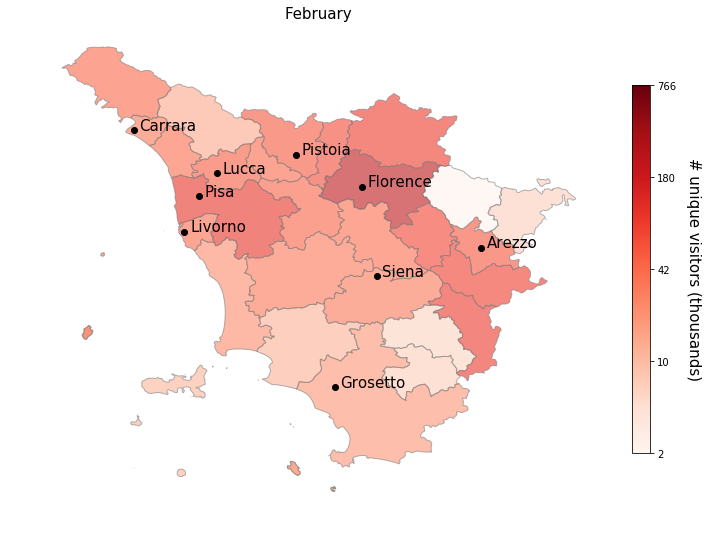

In [13]:
# heatmap plots for each month

# find overall minimum and maximum
min_count_month = []
max_count_month = []
for month, gdf_month in heatmaps_per_month.items():   
    min_count_month.append(gdf_month['count'].min())
    max_count_month.append(gdf_month['count'].max())
min_count = np.array(min_count_month).min()
min_logcount = np.log(min_count)
max_count = np.array(max_count_month).max()
max_logcount = np.log(max_count)

# create monthly heatmaps
for month, gdf_month in heatmaps_per_month.items():
    
    fig = plt.figure(figsize=(11, 9))
    ax = fig.add_subplot(1, 1, 1)    
    
    heatmap_replace_zeros(gdf_month)
    heatmap_plot(gdf_month, ax, clog=[min_logcount, max_logcount], title=month)  
    important_cities(df_impcit)
    
    plt.axis('off')
    plt.savefig(r"/mnt/data/shared/heatmaps/monthly/"+month+".png")

## Histograms of nationalities per month

In [8]:
# query to get the nationalities that visited Tuscany

def query_count_nationality(min_date = '2017-05-01 00:00:00', 
                            max_date = '2018-02-28 23:59:59'):
    
    query="""select mcc, count(distinct customer_id) as num_unique_cus
    from tuscany.vodafone
    where time_stamp between '"""+min_date+"""' and '"""+max_date+"""'
    and customer_id not in (select customer_id from tuscany.excluded_customers)
    group by mcc"""

    number_of_cus_per_country = db.sql_query_to_data_frame(query, cust_id=True)
    
    return number_of_cus_per_country

In [ ]:
# queries for each 'season' (takes a while... go have a coffee)

# create months datetime list
# minimum date is '2017-05-01 00:00:00'
# maximun date is '2017-28-02 23:59:59'
start_dt = datetime(2017, 4, 30, hour=23, minute=59, second=59)
end_dt = datetime(2018, 2, 28, hour=23, minute=59, second=59)
months_dt = []
for i in pd.date_range(start=start_dt, end=end_dt, freq='1M'):
    months_dt.append(str(i + relativedelta(hour=23, minute=59, second=59)))
    
# create dictionary with nationalities for every month
nationality_per_month = {}
for i in range(len(months_dt)-1):
    
    month_start = months_dt[i]
    month_end = months_dt[i+1]
    
    nat_month = query_count_nationality(min_date = month_start, max_date = month_end)
    cur_month = datetime.strptime(months_dt[i+1], "%Y-%m-%d %H:%M:%S").strftime("%B")
    
    nationality_per_month[cur_month] = nat_month  
    print(cur_month)

with open('heatmap_month/natoinality_per_month.pickle', 'wb') as handle:
    pickle.dump(nationality_per_month, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [11]:
with open('/mnt/data/shared/heatmaps/natoinality_per_month.pickle', 'rb') as handle:
    nationality_per_month = pickle.load(handle)

In [12]:
nationality_per_month['May'].head()

mcc  num_unique_cus
0  262           91034
1  460           37303
2  302           17288
3  220            1860
4  452             298

In [13]:
# get the country names from the MCC file and create a column with country name

def clean_guam(row):
    if row['Country']=='Guam':
        return 'United States'
    else:
        return row['Country']

mcc=pd.read_csv('/mnt/data/shared/mcc-mnc-table.csv')
mcc_country=mcc.drop_duplicates("MCC", keep='first')[['MCC', 'Country']]
mcc_country['MCC']=mcc_country['MCC'].astype(int)
mcc_country['Country']=mcc_country.apply(clean_guam,1)


for month, df_nat in nationality_per_month.items():
    df_nat['mcc'] = df_nat['mcc'].astype(int)
    nationality_per_month[month] = df_nat.merge(mcc_country, how = 'inner', left_on='mcc', right_on='MCC')

nationality_per_month['May'].head()

mcc  num_unique_cus  MCC   Country
0  262           91034  262   Germany
1  460           37303  460     China
2  302           17288  302    Canada
3  220            1860  220    Serbia
4  452             298  452  Viet Nam

In [109]:
# shrink the data for the top countries (the others should be in a separate field called others)

for month in nationality_per_month.keys():
    nationality_per_month[month] = nationality_per_month[month].sort_values(by=['num_unique_cus'], ascending=False)
    nationality_per_month[month] = nationality_per_month[month].groupby('Country', as_index=False).aggregate('sum')
    nationality_per_month[month] = nationality_per_month[month].drop(['mcc', 'MCC'], axis=1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 184 entries, 0 to 183
Data columns (total 2 columns):
Country           184 non-null object
num_unique_cus    184 non-null int64
dtypes: int64(1), object(1)
memory usage: 4.3+ KB


In [14]:
#nationality_per_month[month] = nationality_per_month[month].rename(columns={"num_unique_cus": 'May'})    



# find top countries overall
df_counts = pd.DataFrame(nationality_per_month['May']['Country'], columns=['Country'])
for month in list(nationality_per_month.keys())[:]:
    df_counts = df_counts.merge(nationality_per_month[month], how='outer', left_on='Country', right_on='Country')
    df_counts = df_counts.rename(columns={'num_unique_cus': month})
df_counts = df_counts.fillna(0)


# group countries

N_TOPLOT = 9

# find countries with biggest counts
df_counts['Sum'] = df_counts.sum(axis=1)
df_counts = df_counts.sort_values('Sum', ascending=False)
df_counts = df_counts.head(N_TOPLOT)
df_counts = df_counts.drop(columns=['Sum'])

df_counts

Country  mcc_x      May  MCC_x  mcc_y      June  MCC_y  mcc_x  \
0              Germany  262.0  91034.0  262.0  262.0  176581.0  262.0  262.0   
562087          France  208.0  64249.0  208.0  208.0   54109.0  208.0  208.0   
26      United Kingdom  234.0  65661.0  234.0  234.0   86980.0  234.0  234.0   
562066     Netherlands  204.0  49212.0  204.0  204.0   58402.0  204.0  204.0   
286325   United States  310.0  68380.0  310.0  310.0   94318.0  310.0  310.0   
426293   United States  310.0  68380.0  310.0  310.0   94318.0  310.0  310.0   
6389     United States  310.0  68380.0  310.0  310.0   94318.0  310.0  310.0   
146357   United States  310.0  68380.0  310.0  310.0   94318.0  310.0  310.0   
426294   United States  310.0  68380.0  310.0  310.0   94318.0  310.0  310.0   

            July  MCC_x  ...    MCC_x  mcc_y  December  MCC_y  mcc_x  January  \
0       167106.0  262.0  ...    262.0  262.0   21712.0  262.0  262.0  21354.0   
562087  108757.0  208.0  ...    208.0  208.0   33526.0  208.0  208.0  30495.0   
26      102705.0  234.0  ...    234.0  234.0   17731.0  234.0  234.0  16349.0   
562066  110960.0  204.0  ...    204.0  204.0   24542.0  204.0  204.0  27216.0   
286325   83622.0  310.0  ...    310.0  310.0   22748.0  310.0  310.0  24008.0   
426293   83622.0  310.0  ...    310.0  310.0   22748.0  310.0  310.0  24008.0   
6389     83622.0  310.0  ...    310.0  310.0   22748.0  310.0  310.0  24008.0   
146357   83622.0  310.0  ...    310.0  310.0   22748.0  310.0  310.0  24008.0   
426294   83622.0  310.0  ...    310.0  310.0   22748.0  310.0  310.0  24008.0   

        MCC_x  mcc_y  February  MCC_y  
0       262.0  262.0   18846.0  262.0  
562087  208.0  208.0   32030.0  208.0  
26      234.0  234.0   19729.0  234.0  
562066  204.0  204.0   41201.0  204.0  
286325  310.0  310.0   21050.0  310.0  
426293  310.0  310.0   21050.0  310.0  
6389    310.0  310.0   21050.0  310.0  
146357  310.0  310.0   21050.0  310.0  
426294  310.0  311.0    6824.0  311.0  

[9 rows x 31 columns]

In [31]:
df_counts.columns[0][:3]

'Cou'

In [33]:
relevant=[]
for col in df_counts.columns:
    if col.lower()[:3]!='mcc':
        relevant.append(col)

In [42]:
import seaborn as sns

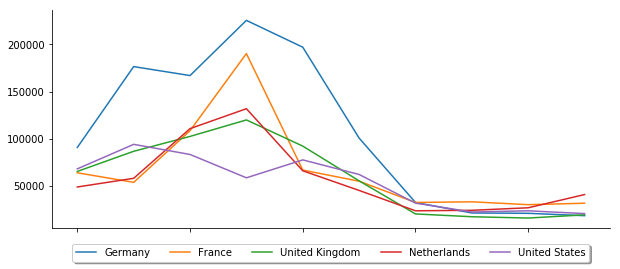

In [77]:
ax=df_counts[relevant].set_index('Country').T.T[:-4].T.plot(figsize=(10, 4))
sns.despine()
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)


In [45]:
counts=df_counts[relevant].set_index('Country').T.T[:-4].T

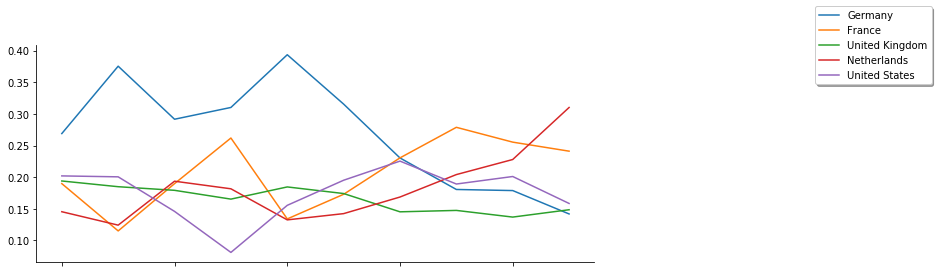

In [97]:
df=(counts.T / counts.T.sum()).T
ax=df.plot(figsize=(10,4))
sns.despine(top=True, right=True, bottom=False
            ,left=False)
ax.legend(loc='upper center', bbox_to_anchor=(1.5, +1.2),
          fancybox=True, shadow=True, ncol=1)


## Where are turists coming from 

 - This can be done by looking at the municipality where they first show up in Tuscany

In [22]:
### run query for the full sample
# removed all the customers we discussed should be removed
query = """
select locations 
from tuscany.customer_arrays
where customer_id not in (select customer_id from tuscany.excluded_customers)
"""
df_trips = db.sql_query_to_data_frame(query, cust_id=True)
with open('heatmap_month/df_trips.pickle', 'wb') as handle:
    pickle.dump(df_trips, handle, protocol=pickle.HIGHEST_PROTOCOL)
df_trips.head()

locations
0     48017
1     48017
2     48017
3     48017
4     49009

In [16]:
with open('heatmap_month/df_trips.pickle', 'rb') as handle:
    df_trips = pickle.load(handle)

In [17]:
# replace str of locations by list of strs with pro_com
# (takes a minute for the full dataset)

# str to list of PRO_COM
tic = time.time()
df_trips['locations'] = df_trips['locations'].str.split(', ').tolist()
toc = time.time()
print('Number of individual trips:', df_trips.shape[0])

Number of individual trips: 6194002


In [18]:
# remove trips with only one municipality

df_trips = df_trips[df_trips['locations'].apply(len) > 1] 
df_trips = df_trips.reset_index()[['locations']]         # this reduces the size of the DataFrame (a bit)
df_trips.shape
print('Reduced number of individual trips:', df_trips.shape[0])

Reduced number of individual trips: 5781464


In [19]:
# A bit of descriptives

df_trips_len = df_trips['locations'].apply(len)
print('Mean number of visited municipalities =', df_trips_len.mean())
print('Median number of visited municipalities =', int(df_trips_len.median()))
print('Min number of visited municipalities =', df_trips_len.min())
print('Max number of visited municipalities =', df_trips_len.max())

Mean number of visited municipalities = 31.701101831646795
Median number of visited municipalities = 18
Min number of visited municipalities = 2
Max number of visited municipalities = 472


In [217]:
# find out arrival municipality (arrival in Italy!)

def arrival_mun(trip):
    
    return trip[0]

df_arrival_mun = df_trips['locations'].apply(arrival_mun)
df_arrival_fre = pd.DataFrame(df_arrival_mun.value_counts())
df_arrival_fre['PRO_COM'] = df_arrival_fre.index
df_arrival_fre.head()

NameError: name 'df_trips' is not defined

(6.0319333482760005, 19.115069605015037, 34.91378733591511, 47.671688331985)

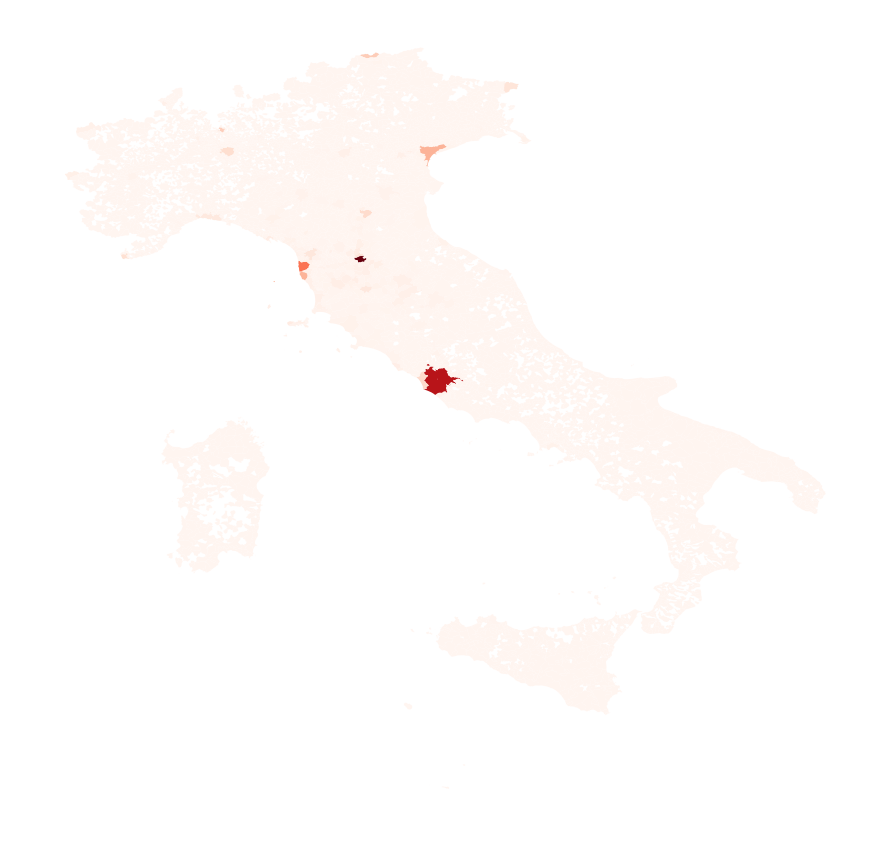

In [21]:
# heatmap of entrance municipalities (arrival in Italy!)

gdf_mun_merged = gdf_mun.merge(df_arrival_fre.astype(int), how = 'inner', left_on='PRO_COM', right_on='PRO_COM')

fig = plt.figure(figsize=(15, 15))
ax = plt.subplot(1,1,1)
gdf_mun_merged.plot(column='locations', cmap='Reds', ax=ax)
plt.axis('off')

(9.552467742534965, 12.5055871082731, 42.12652066388761, 44.5844306661525)

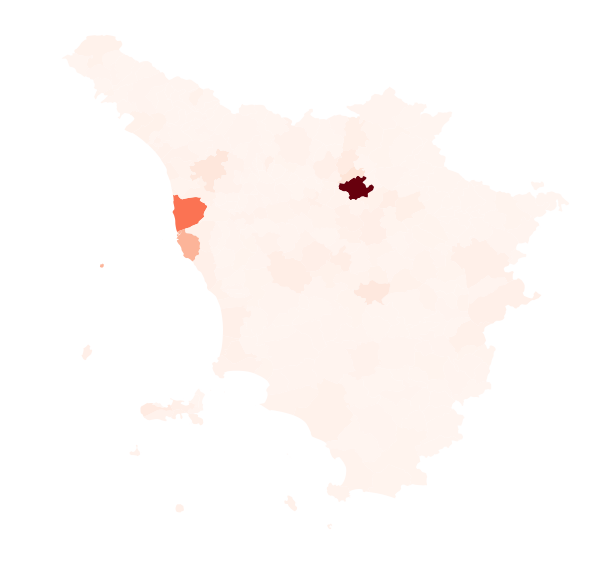

In [22]:
# heatmap of entrance municipalities (arrival in Italy)

gdf_mun_tus_merged = gdf_mun_tus.merge(df_arrival_fre.astype(int), how = 'inner', left_on='PRO_COM', right_on='PRO_COM')

fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(1,1,1)
gdf_mun_tus_merged.plot(column='locations', cmap='Reds', ax=ax)
plt.axis('off')

In [56]:
# find out arrival municipality (arrival in Tuscany!)

def arrival_mun_tus(trip):
    
    return [int(m) for m in trip if int(m) in gdf_mun_tus['PRO_COM'].tolist()]

tic = time.time()
df_trips_tus = df_trips['locations'].apply(arrival_mun_tus)
toc = time.time()
print(toc-tic, 'seconds')

with open('heatmap_month/df_trips_tus.pickle', 'wb') as handle:
    pickle.dump(df_trips_tus, handle, protocol=pickle.HIGHEST_PROTOCOL)
df_trips_tus.head()

4646.6251010894775 seconds


0                                              [46013]
1    [51001, 51034, 48038, 48028, 48036, 51002, 510...
2    [48021, 52023, 52006, 52013, 52032, 52022, 520...
3    [48018, 48053, 48043, 48017, 48014, 48028, 480...
4                                       [52032, 51018]
Name: locations, dtype: object

In [215]:
with open('heatmap_month/df_trips_tus.pickle', 'rb') as handle:
    df_trips_tus = pickle.load(handle)

In [218]:
# filter arrival municipality

df_entrance_tus = df_trips_tus.apply(arrival_mun)

In [219]:
# count the number of entrances per municipality

df_entrance_tus_counts = pd.DataFrame(df_entrance_tus.value_counts())
df_entrance_tus_counts['PRO_COM'] = df_entrance_tus_counts.index
df_entrance_tus_counts.columns = ['counts', 'PRO_COM']
df_entrance_tus_counts.head()

counts  PRO_COM
48017  857310    48017
48002  608771    48002
50026  327763    50026
45014  250904    45014
48005  197797    48005

(9.552467742534965, 12.5055871082731, 42.12652066388761, 44.5844306661525)

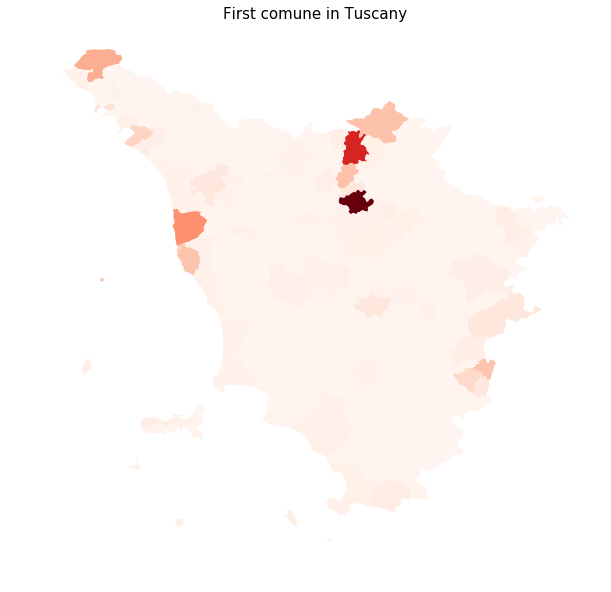

In [220]:
# heatmap of entrance municipalities (arrival in Tuscany!)

gdf_mun_tus_merged = gdf_mun_tus.merge(df_entrance_tus_counts.astype(int), how = 'inner', left_on='PRO_COM', right_on='PRO_COM')

fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(1,1,1)
gdf_mun_tus_merged.plot(column='counts', cmap='Reds', ax=ax)
plt.title('First comune in Tuscany', fontsize=15)
plt.axis('off')

## Arrivals by type of transportation

In [8]:
# query for starting lat and lon in Italy

query = """
select start_lat, start_lon, mon_arvl_tusc, day_arvl_tusc
from tpt.tuscany.customer_feature
where customer_id not in (select customer_id from tuscany.excluded_customers)
order by tpt.tuscany.customer_feature.mon_arvl_tusc
"""
df_arrivals = db.sql_query_to_data_frame(query, cust_id=True)

with open('heatmap_month/df_arrivals.pickle', 'wb') as handle:
    pickle.dump(df_arrivals, handle, protocol=pickle.HIGHEST_PROTOCOL)
df_arrivals.head()

start_lat  start_lon mon_arvl_tusc day_arvl_tusc
0  41.883400  12.489800             1             1
1  41.967900  12.409600             1             1
2  43.793100  11.218200             1             1
3  41.883400  12.489800             1             1
4  44.162200   9.614600             1             1

(6.031933348276, 19.115069605015037, 34.91378733591511, 47.671688331985)

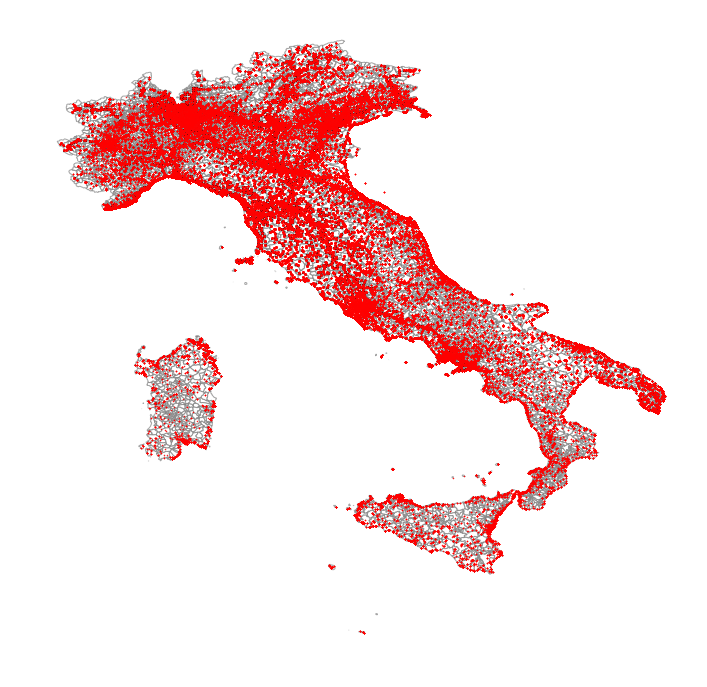

In [12]:
fig  = plt.figure(figsize=(12, 12))
ax = plt.subplot(1,1,1)

gdf_mun.plot(ax=ax, color='white', edgecolor='gray', alpha=0.7)

plt.plot(df_arrivals['start_lon'].iloc[:], df_arrivals['start_lat'].iloc[:], 'ro', markersize=0.5)


plt.axis('off')

In [13]:
# query for starting lat and lon in Tuscany

query = """
select lat, lon, num_airport, coast, pisa, florence
from tpt.tuscany.customer_feature as c
inner join tpt.tuscany.location_features as l
on c.loc_arvl_tusc = l.location_i
"""
df_arrivals_tus = db.sql_query_to_data_frame(query, cust_id=True)

with open('heatmap_month/df_arrivals_tusc.pickle', 'wb') as handle:
    pickle.dump(df_arrivals_tus, handle, protocol=pickle.HIGHEST_PROTOCOL)
df_arrivals_tus.head()

lat        lon num_airport coast pisa florence
0  43.617300  11.174900           0     0    0        0
1  43.011400  11.939300           0     0    0        0
2  43.540000  11.321400           0     0    0        0
3  43.702300  10.573500           0     0    0        0
4  43.958400  10.179800           0     0    0        0

In [31]:
df_arrivals_tus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5647132 entries, 0 to 5647131
Data columns (total 6 columns):
lat            object
lon            object
num_airport    object
coast          object
pisa           object
florence       object
dtypes: object(6)
memory usage: 258.5+ MB


In [15]:
with open('heatmap_month/df_arrivals_tusc.pickle', 'rb') as handle:
    df_arrivals_tus = pickle.load(handle)

(9.552467742534965, 12.5055871082731, 42.12652066388761, 44.5844306661525)

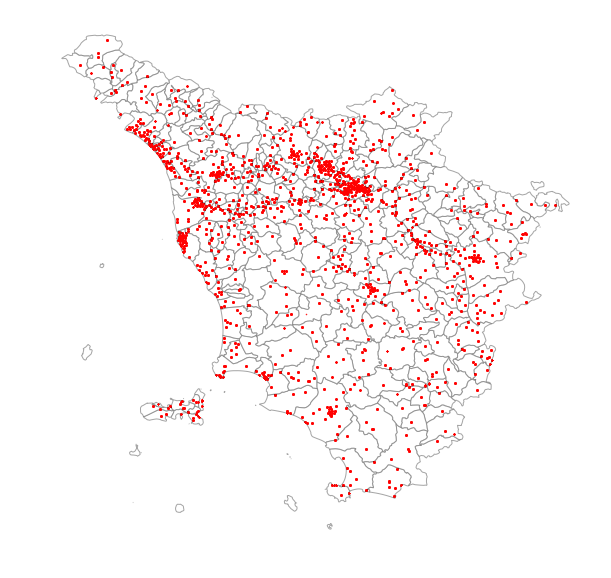

In [18]:
# plot map of arrival locations in Tuscany

fig  = plt.figure(figsize=(10, 10))
ax = plt.subplot(1,1,1)

gdf_mun_tus.plot(ax=ax, color='white', edgecolor='gray', alpha=0.7)

plt.plot(df_arrivals_tus['lon'].iloc[:], df_arrivals_tus['lat'].iloc[:], 'ro', markersize=0.5)

plt.axis('off')

In [ ]:
# plot heatmap of arrival locations in Tuscany

query="""
select pro_com
from tpt.tuscany.location_dictionary as l
inner join tpt.tuscany.customer_feature as c
on l.location_id = c.loc_arvl_tusc
where c.customer_id not in (select customer_id from tuscany.excluded_customers)
"""
df_arrivals_tus_procom = db.sql_query_to_data_frame(query, cust_id=True)

with open('heatmap_month/df_arrivals_tus_procom.pickle', 'wb') as handle:
    pickle.dump(df_arrivals_tus_procom, handle, protocol=pickle.HIGHEST_PROTOCOL)
df_arrivals_tus_procom.head()

In [ ]:
with open('heatmap_month/df_arrivals_tus_procom.pickle', 'rb') as handle:
    df_arrivals_tus_procom = pickle.load(handle)

In [40]:
# coutns and sanity check

df_entrance_procom = pd.DataFrame(df_arrivals_tus_procom['pro_com'].value_counts())
df_entrance_procom['PRO_COM'] = df_entrance_procom.index
df_entrance_procom.columns = ['counts', 'PRO_COM']
df_entrance_procom.head()

counts PRO_COM
48017  1127670   48017
48002   609075   48002
50026   340899   50026
45014   251187   45014
49009   227604   49009

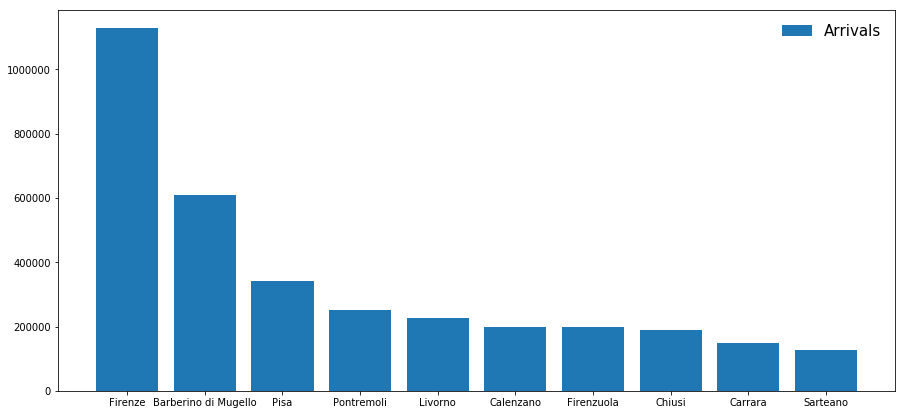

In [58]:
# histogram of arrivals

N_COMUNES = 10

gdf_entrance = gdf_mun_tus.merge(df_entrance_procom.astype(int), how = 'inner', left_on='PRO_COM', right_on='PRO_COM')
gdf_entrance = gdf_entrance.sort_values(by=['counts'], ascending=False)

names = gdf_entrance['COMUNE'][:N_COMUNES].tolist()
procoms = gdf_entrance['PRO_COM'][:N_COMUNES].tolist()
values = gdf_entrance['counts'][:N_COMUNES].tolist()

fig = plt.figure(figsize=(15, 7))
ax = plt.subplot(1,1,1)
plt.bar(range(len(procoms)), values, tick_label=names, label='Arrivals')
plt.legend(loc='best', frameon=False, fontsize=15)

In [62]:
# who arrives in a coast or an airport?

df_arrivals_tus['florence'].astype(int).sum()

1259

In [258]:
# is it easy for you to write a function which given the list of 
# communes as an array or something can plot the trajectory on the italian map?

def function_for_KM(list_of_comunes=False):
    '''
    Parameters:
    
        list_of_comunes: list of pro_com (as ints)    
    '''
    
    # comune centroids 
    df_centroids = pd.read_csv(r"/mnt/data/shared/comune_centroids.csv")
        
    fig = plt.figure(figsize=(15, 15))
    ax = plt.subplot(1,1,1)
    
    gdf_mun.plot(ax=ax, color='white', edgecolor='gray', alpha=0.5)
    
    if list_of_comunes is not False:
        
        trip = pd.DataFrame(list_of_comunes, columns=['PRO_COM'])
        trip = trip.merge(df_centroids, how='inner', left_on='PRO_COM', right_on='pro_com')
        
    plt.plot(trip['lat'], trip['lon'], '-o')
    plt.axis('off')


#trip_example = [1001, 1002, 1003, 1004, 94020]   
#function_for_KM(list_of_comunes=trip_example)   
    

In [233]:
query='''
select com_locs_new from tuscany.customer_arrays
where customer_nr in (6826329, 2497526, 7092822, 6532525, 6851789)
'''
df_trips = db.sql_query_to_data_frame(query, cust_id=True)
df_trips.head()

com_locs_new
0                                       52032, 48017
1  40033, 48020, 50016, 50039, 50012, 50039, 5001...
2                         48008, 48028, 48014, 46017
3                                       48017, 50026
4  27042, 27028, 28060, 28001, 28003, 28057, 2801...

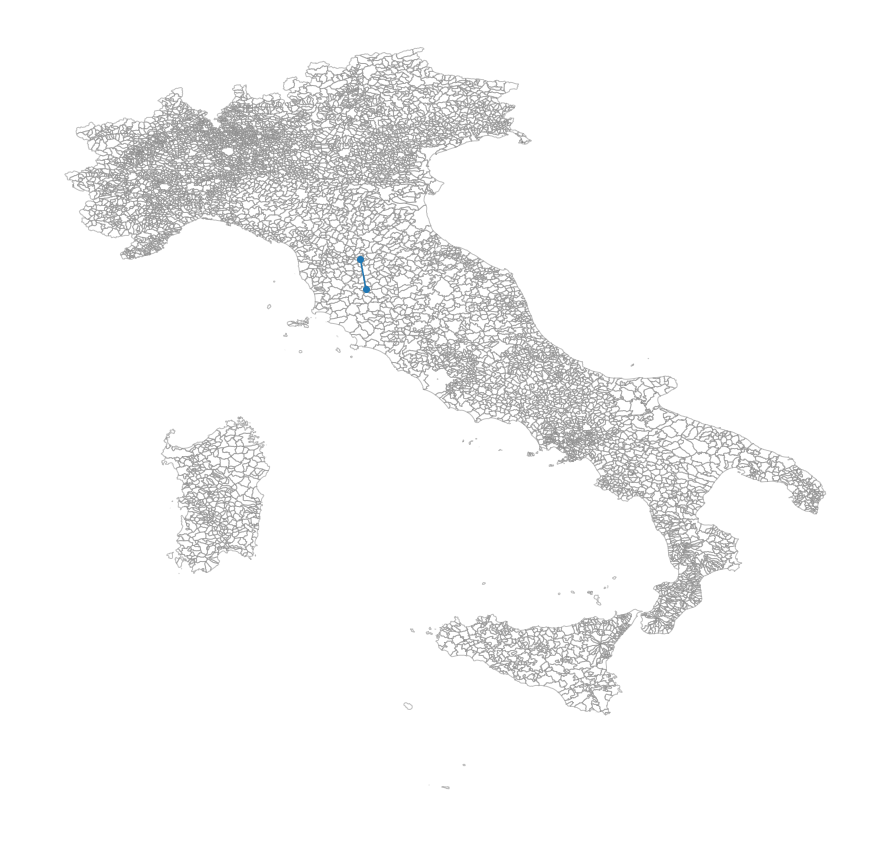

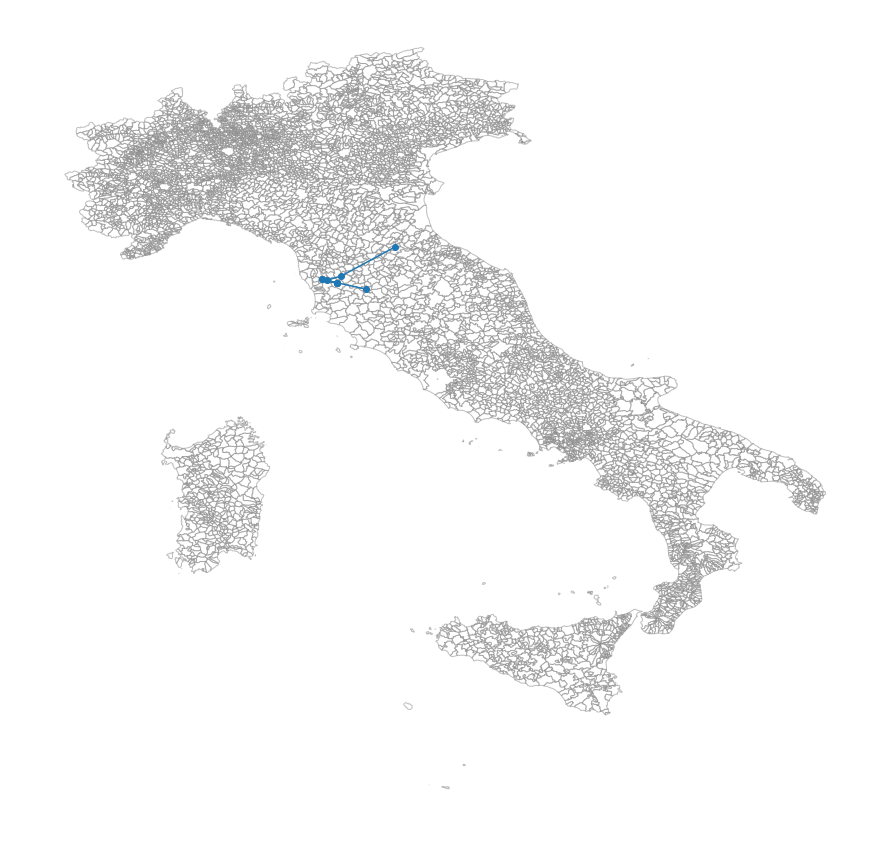

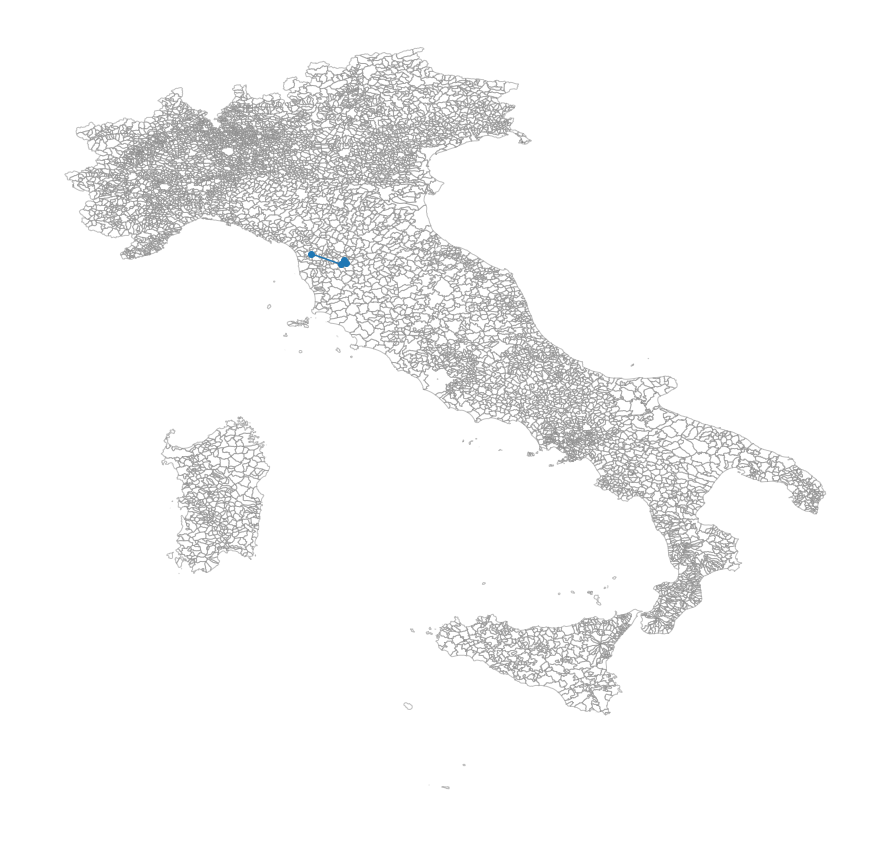

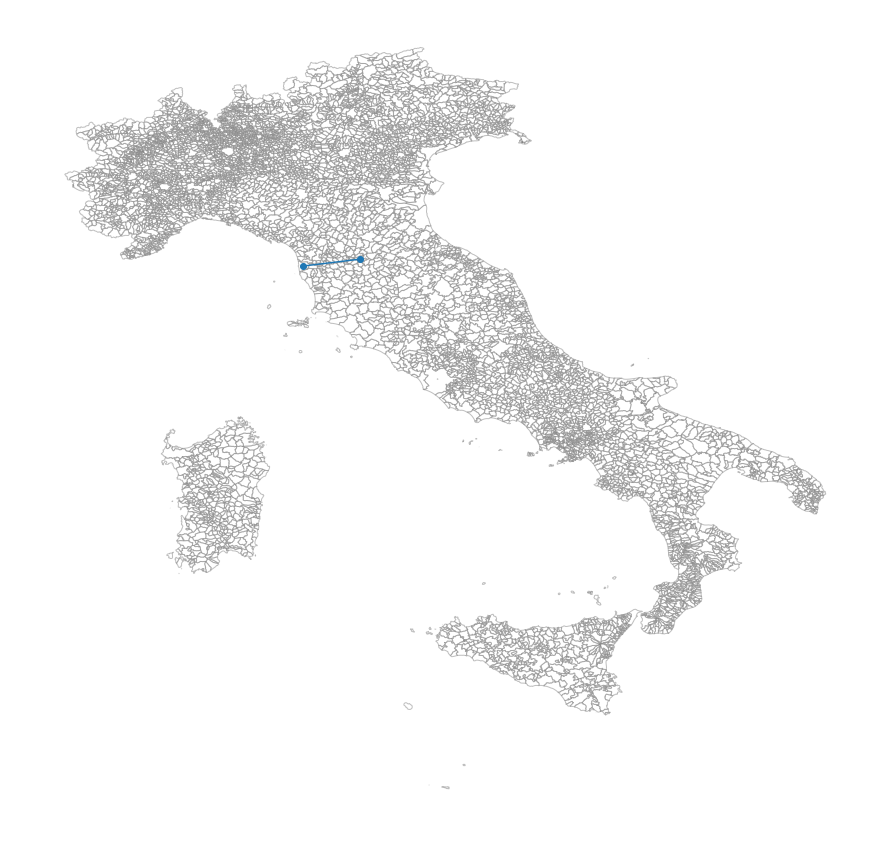

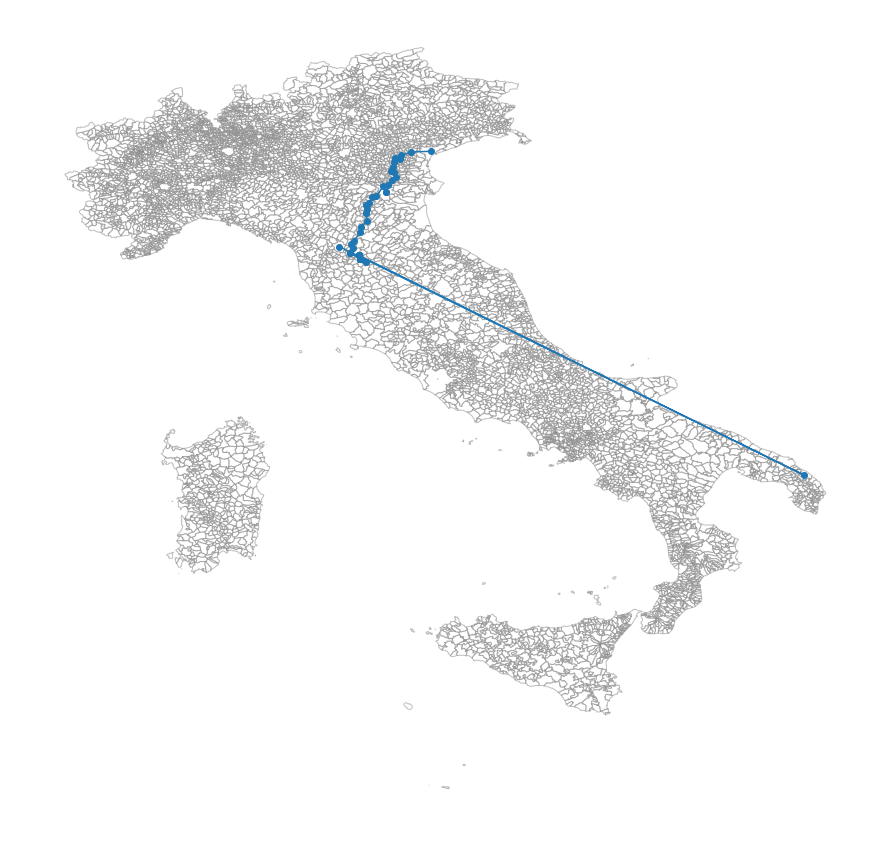

In [259]:
for trip in df_trips['com_locs_new'].tolist():
    function_for_KM(list_of_comunes=list(map(int, trip.split(', '))))